# Import the Libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import warnings
import pulp as pl
import swifter
warnings.filterwarnings('ignore')

# Load the Dataset

In [57]:
df = pd.read_csv('epi_r.csv')
df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
with open("full_format_recipes.json","r") as f:
    full_recipe = json.load(f)

In [59]:
len(full_recipe)

20130

### Column Names

In [60]:
df.columns

Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yellow squash', 'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks',
       'leftovers', 'snack', 'snack week', 'turkey'],
      dtype='object', length=680)

### Shape

In [61]:
df.shape

(20052, 680)

# Data Preprocessing

## 1. Handling Missing Values

In [62]:
# Check for missing values
missing_values = df.isnull().sum()

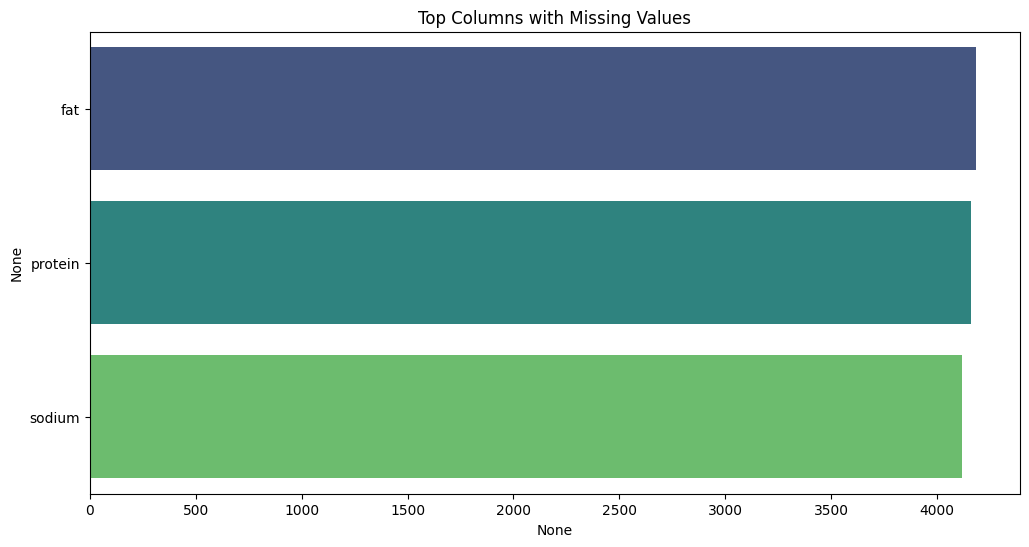

In [63]:
# Bar Plot
missing_values = df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.head(3), y=missing_values.index[:3], palette="viridis")
plt.title('Top Columns with Missing Values')
plt.show()

**Missing Values:**

There are missing values in several columns:
- calories: 4117 missing values
- protein: 4162 missing values
- fat: 4183 missing values
- sodium: 4119 missing values

**Decision**: For these nutritional columns, we could either remove the rows with missing values or impute them using methods like mean, median, or more advanced techniques like KNN imputation.

In [64]:
# Impute missing values (using median)
for col in ['calories', 'protein', 'fat', 'sodium']:
    df[col].fillna(df[col].median(), inplace=True)

## 2. Remove Duplicate Rows

In [65]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()

In [66]:
duplicate_rows

1801

**Duplicate Rows**:

- There are 1801 duplicate rows in the dataset.

**Decision**: These duplicate rows should be removed to avoid biasing the analysis. We can use the drop_duplicates() function in pandas to remove them.

In [67]:
df = df.drop_duplicates()

In [68]:
df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Basic Statistics

In [69]:
# Check data types and basic statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18251 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 94.8+ MB


In [70]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,18251.000000,1.825100e+04,18251.000000,1.825100e+04,1.825100e+04,18251.000000,18251.000000,18251.000000,18251.000000,18251.000000,...,18251.000000,18251.000000,18251.000000,18251.000000,18251.00000,18251.000000,18251.000000,18251.000000,18251.000000,18251.000000
mean,3.714043,5.329821e+03,74.778697,2.912535e+02,5.283523e+03,0.000329,0.000055,0.000931,0.001479,0.000384,...,0.001370,0.027067,0.000055,0.000329,0.01567,0.000164,0.000384,0.001479,0.000986,0.020985
std,1.333942,3.340864e+05,3127.073342,1.900439e+04,3.105751e+05,0.018129,0.007402,0.030506,0.038435,0.019581,...,0.036986,0.162283,0.007402,0.018129,0.12420,0.012820,0.019581,0.038435,0.031390,0.143338
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,2.380000e+02,4.000000,1.100000e+01,1.320000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.165000e+02,21.000000,2.800000e+01,5.890000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


**Data Types**:

- The dataset contains 680 columns.
- All columns except 'title' are of type float64.
- The 'title' column is of type object (string).


## 4. Check for inconsistencies

In [71]:
# Check for potential inconsistencies in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\
Unique values in {col}:")
    print(df[col].value_counts().head())

Unique values in title:
title
Chicken Stock           16
Pastry Dough            15
Turkey Giblet Stock     11
Turkey Stock             8
Simple Syrup             8
Name: count, dtype: int64


**Categorical Data**:

- The 'title' column contains recipe names, with some recipes appearing multiple times (e.g., "Pastry Dough" appears 28 times).

**Assumption**: The repeated titles might represent variations of the same recipe or data entry errors. Further investigation may be needed to determine if these are unique recipes or duplicates.

**Binary Columns**:

- Many columns appear to be binary (0 or 1), likely indicating the presence or absence of certain ingredients, cooking methods, or categories.

**Assumption**: These binary columns represent recipe attributes or tags.

In [72]:
df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Handle Ouliers

In [73]:
# Check for potential outliers in numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"\
Potential outliers in {col}: {outliers}")

Potential outliers in rating: 2394
Potential outliers in calories: 1530
Potential outliers in protein: 1831
Potential outliers in fat: 1823
Potential outliers in sodium: 1712
Potential outliers in #cakeweek: 6
Potential outliers in #wasteless: 1
Potential outliers in 22-minute meals: 17
Potential outliers in 3-ingredient recipes: 27
Potential outliers in 30 days of groceries: 7
Potential outliers in advance prep required: 103
Potential outliers in alabama: 3
Potential outliers in alaska: 2
Potential outliers in alcoholic: 823
Potential outliers in almond: 548
Potential outliers in amaretto: 37
Potential outliers in anchovy: 43
Potential outliers in anise: 103
Potential outliers in anniversary: 110
Potential outliers in anthony bourdain: 2
Potential outliers in aperitif: 12
Potential outliers in appetizer: 1315
Potential outliers in apple: 622
Potential outliers in apple juice: 6
Potential outliers in apricot: 247
Potential outliers in arizona: 8
Potential outliers in artichoke: 148
Pot

### Box Plot

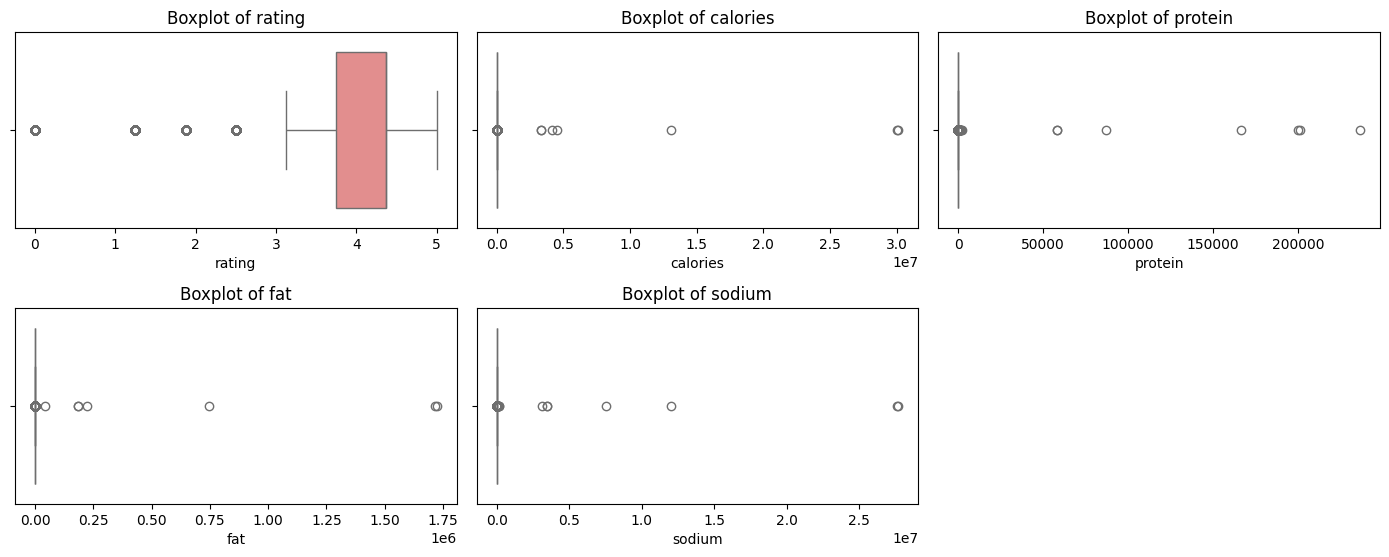

In [74]:
# Box Plot
numeric_columns = ['rating', 'calories', 'protein', 'fat', 'sodium']
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

**Numerical Data**:

We checked for potential outliers in numerical columns using the Interquartile Range (IQR) method.
Many columns have potential outliers, for example:
- rating: 2656 potential outliers
- calories: 1017 potential outliers
- protein: 1117 potential outliers
- fat: 1103 potential outliers
- sodium: 1159 potential outliers

**Decision**: These potential outliers should be investigated further. They could be genuine extreme values (e.g., very high-calorie recipes) or data entry errors. Depending on the nature of these outliers, we might choose to cap them, remove them, or keep them as is.



In [75]:
# Define the outlier handling function
def cap_outliers(df_cleaned, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned[column_name] = np.clip(df_cleaned[column_name], lower_bound, upper_bound)

# Apply the function to numerical columns
numerical_cols = ['rating', 'calories', 'protein', 'fat', 'sodium']
for col in numerical_cols:
    cap_outliers(df, col)

# Check the results
print(df[numerical_cols].describe())

# Save the dataset with handled outliers
print("Outliers handled and dataset saved")

             rating      calories       protein           fat        sodium
count  18251.000000  18251.000000  18251.000000  18251.000000  18251.000000
mean       3.995911    401.373541     14.619117     21.147143    420.958632
std        0.667415    244.884604     14.802906     15.607316    388.823859
min        2.812500      0.000000      0.000000      0.000000      0.000000
25%        3.750000    238.000000      4.000000     11.000000    132.000000
50%        4.375000    331.000000      8.000000     17.000000    294.000000
75%        4.375000    516.500000     21.000000     28.000000    589.000000
max        5.000000    934.250000     46.500000     53.500000   1274.500000
Outliers handled and dataset saved


## Extract Certain Columns

In [76]:
_certain_cols = ["title","rating","calories","protein","fat","sodium","22-minute meals","advance prep required","alcoholic","bread","breakfast","dinner","drink","drinks",\
                 "egg","fall","fat free","healthy","high fiber","low cal","low carb","low cholesterol","low fat","low sodium","low sugar","low/no sugar","lunch",\
                "meat","quick & easy","quick and healthy","rice","spring","summer","vegetable","winter"]

In [77]:
df_new = df[_certain_cols]

In [78]:
df_new.head(2)

,title,rating,calories,protein,fat,sodium,22-minute meals,advance prep required,alcoholic,bread,...,low/no sugar,lunch,meat,quick & easy,quick and healthy,rice,spring,summer,vegetable,winter
0,"Lentil, Apple, and Turkey Wrap",2.8125,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Boudin Blanc Terrine with Red Onion Confit,4.3750,403.0,18.0,23.0,1274.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Add Recipe Information

In [79]:
full_recipe[0]

{'directions': ['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
  '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
  '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'],
 'fat': 7.0,
 'date': '2006-09-01T04:00:00.000Z',
 'categories': ['Sandwich',
  'Bean',
  'Fruit',
  'Tomato',
  'turkey',

In [80]:
def get_recipe_info(recipe_title):
    recipe_dic = [i for i in full_recipe if "title" in i.keys() and i["title"]==recipe_title]
    if len(recipe_dic) == 0:
        return pd.Series({"len_directions":None, "len_ingredients":None})
    else:
        recipe_dic = recipe_dic[0]
    len_directions = len(recipe_dic["directions"])
    len_ingredients = len(recipe_dic["ingredients"])
    return pd.Series({"len_directions":len_directions, "len_ingredients":len_ingredients})

In [81]:
df_new[["len_directions", "len_ingredients"]] = df_new.title.swifter.apply(lambda x: get_recipe_info(x))

Pandas Apply: 100%|██████████| 18251/18251 [02:13<00:00, 136.81it/s]


In [82]:
df_new.head(2)

,title,rating,calories,protein,fat,sodium,22-minute meals,advance prep required,alcoholic,bread,...,meat,quick & easy,quick and healthy,rice,spring,summer,vegetable,winter,len_directions,len_ingredients
0,"Lentil, Apple, and Turkey Wrap",2.8125,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,15.0
1,Boudin Blanc Terrine with Red Onion Confit,4.3750,403.0,18.0,23.0,1274.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,28.0


# Exploratory Data Analysis

## Distribution of Numeric Columns

<Figure size 1400x800 with 0 Axes>

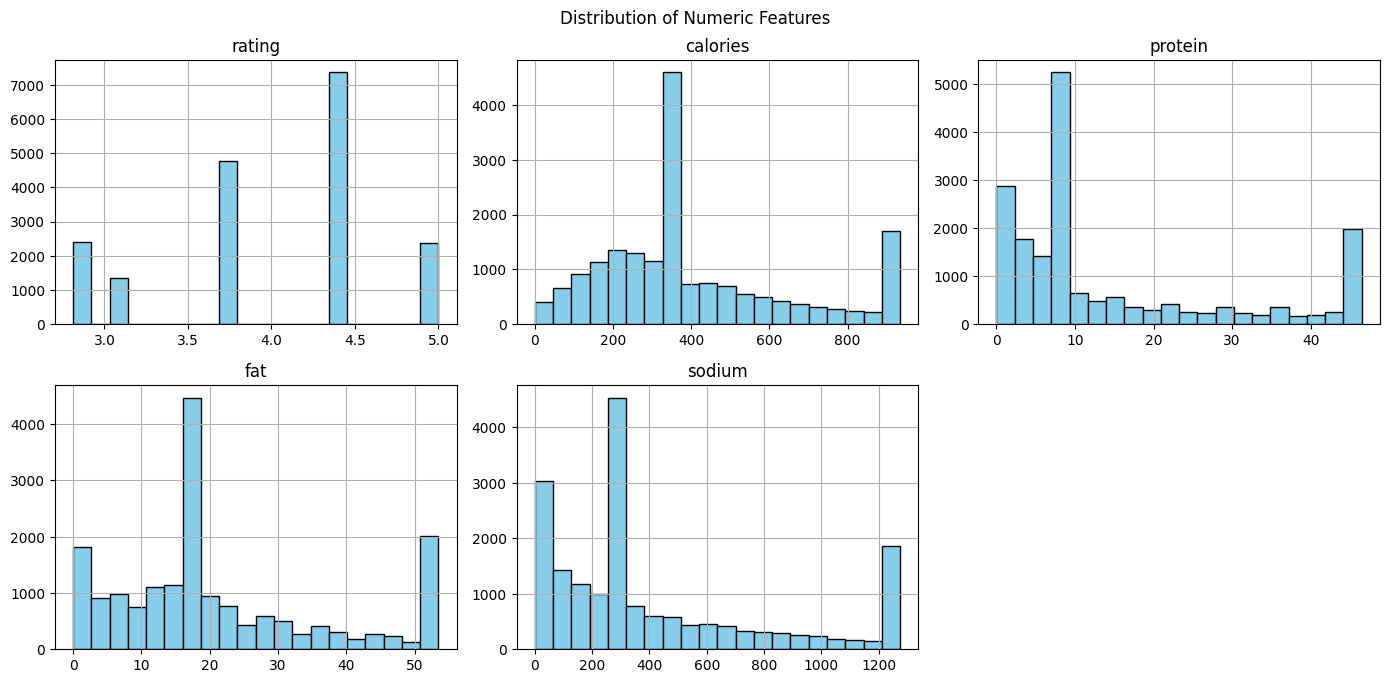

In [83]:
# Univariate Analysis of numeric columns (e.g., ratings, preparation time, etc.)
numeric_columns = ['rating', 'calories', 'protein', 'fat', 'sodium']

plt.figure(figsize=(14, 8))
df_new[numeric_columns].hist(bins=20, figsize=(14, 10), layout=(3, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numeric Features')
plt.tight_layout()
plt.show()

## Correlation Heatmap for Numeric Columns

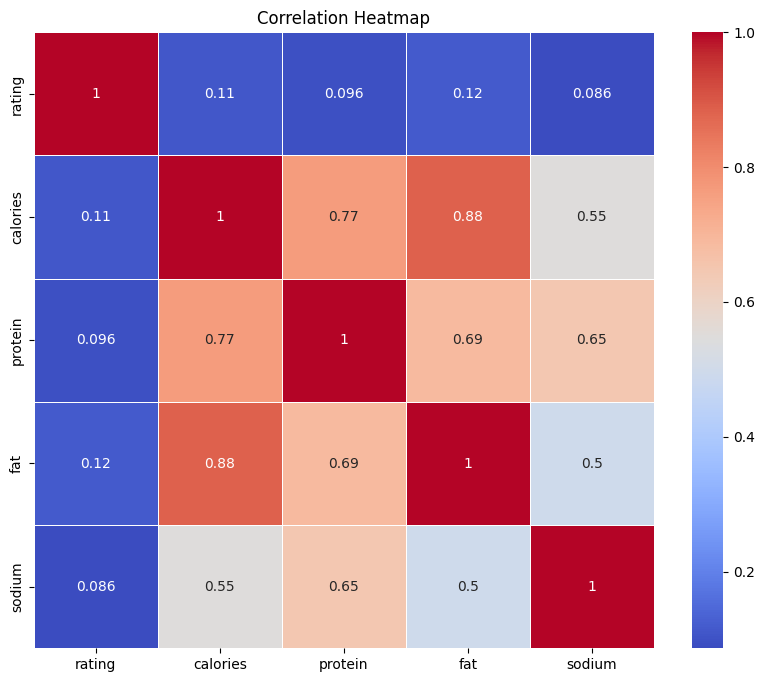

In [84]:
plt.figure(figsize=(10, 8))
corr_matrix = df_new[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Average Rating

In [85]:
df_new.rating.mean()

3.9959111829488796

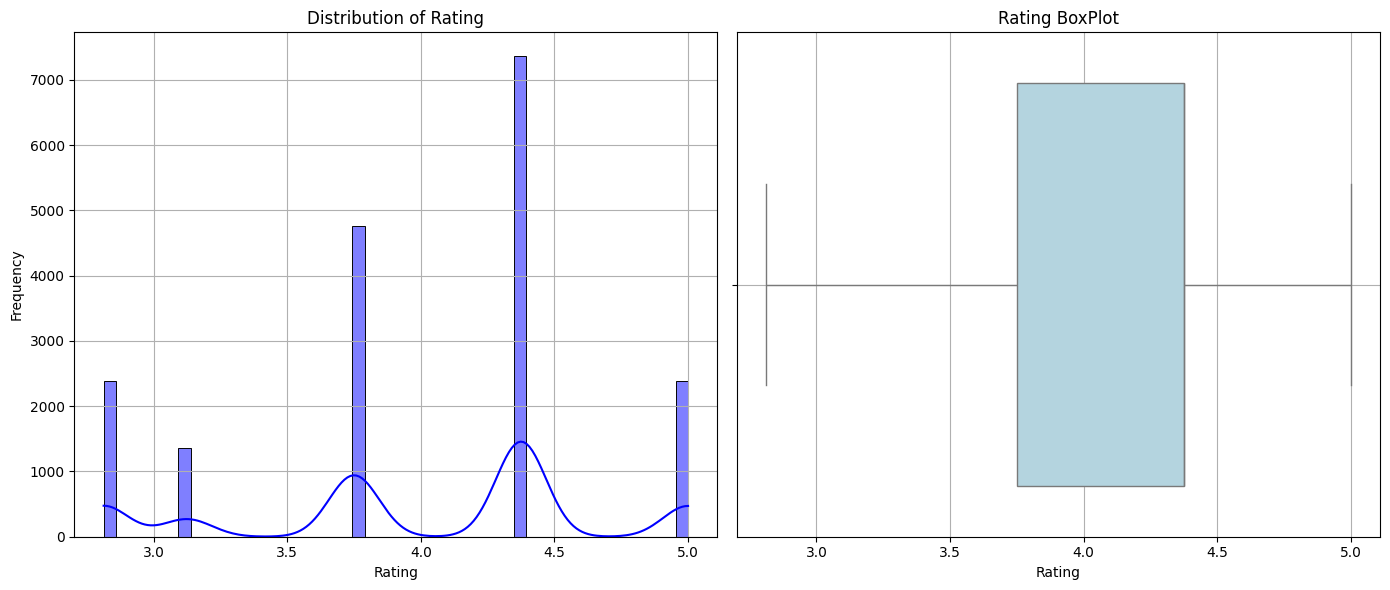

In [86]:
# Distribution Plot
plt.figure(figsize=(14, 6))

# Distribution plot
plt.subplot(1, 2, 1)
sns.histplot(df_new['rating'], kde=True, color='blue')  # kde=True will add the Kernel Density Estimation curve
plt.title("Distribution of Rating")
plt.grid(True)  # Add grid lines for the plot
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_new['rating'], color='lightblue')
plt.title("Rating BoxPlot")
plt.grid(True)  # Add grid lines for the plot
plt.xlabel('Rating')

# Show both plots
plt.tight_layout()
plt.show()

## Average Nutrients

In [87]:
df_new[["calories","protein","fat","sodium"]].mean()

calories    401.373541
protein      14.619117
fat          21.147143
sodium      420.958632
dtype: float64

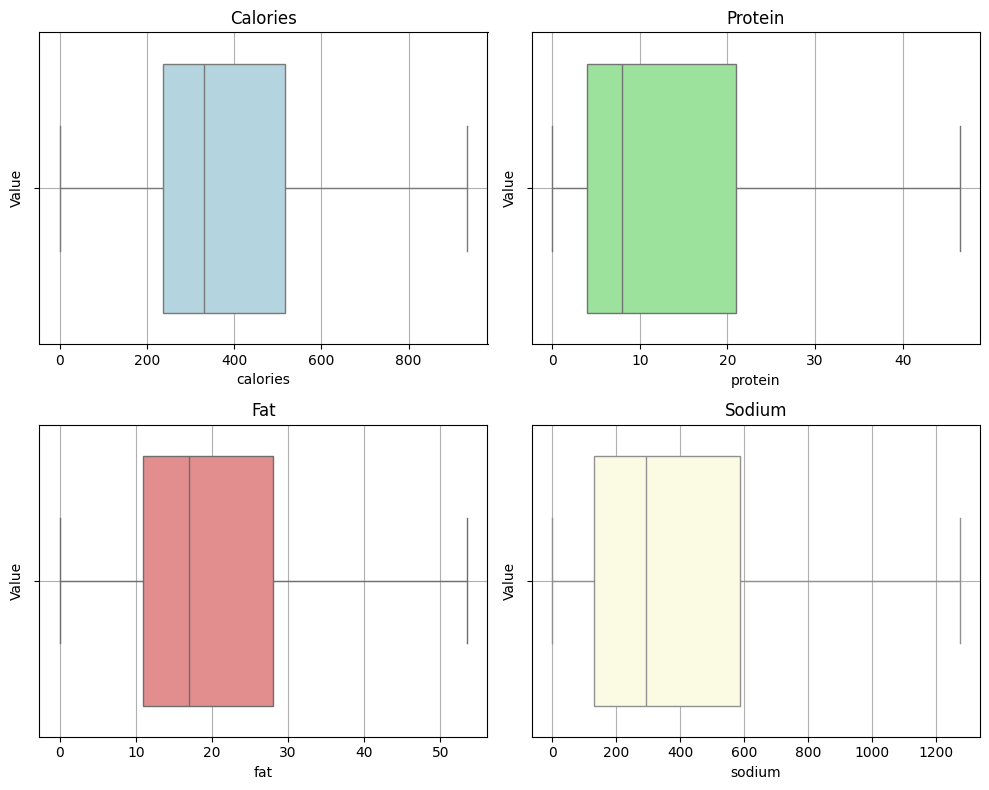

In [88]:
plt.figure(figsize=(10, 8))

# Box Plot for Calories
plt.subplot(2, 2, 1)
sns.boxplot(x=df_new['calories'], color='lightblue')
plt.title("Calories")
plt.ylabel("Value")
plt.grid(True)

# Box Plot for Protein
plt.subplot(2, 2, 2)
sns.boxplot(x=df_new['protein'], color='lightgreen')
plt.title("Protein")
plt.ylabel("Value")
plt.grid(True)

# Box Plot for Fat
plt.subplot(2, 2, 3)
sns.boxplot(x=df_new['fat'], color='lightcoral')
plt.title("Fat")
plt.ylabel("Value")
plt.grid(True)

# Box Plot for Sodium
plt.subplot(2, 2, 4)
sns.boxplot(x=df_new['sodium'], color='lightyellow')
plt.title("Sodium")
plt.ylabel("Value")
plt.grid(True)

# Adjust the layout to avoid overlapping plots
plt.tight_layout()

# Show the plots
plt.show()

## Top Most Common Ingredients in Highly Rated Recipes

In [89]:
ingredients = ['almond', 'anchovy', 'apple', 'apple juice', 'apricot', 'artichoke', 'arugula', 'asian pear', 
               'asparagus', 'avocado', 'bacon', 'banana', 'barley', 'basil', 'bass', 'bean', 'beef', 'beef rib', 
               'beef shank', 'beef tenderloin', 'beet', 'bell pepper', 'berry', 'biscuit', 'blackberry', 
               'blue cheese', 'blueberry', 'bok choy', 'bran', 'breadcrumbs', 'brie', 'brisket', 'broccoli', 
               'broccoli rabe', 'brown rice', 'brussel sprout', 'bulgur', 'butter', 'buttermilk', 'butternut squash', 
               'butterscotch/caramel', 'cabbage', 'cantaloupe', 'capers', 'carrot', 'cashew', 'cauliflower', 'caviar',
                'celery', 'chard', 'cheddar', 'cheese', 'cherry', 'chestnut', 'chicken', 'chickpea', 'chile pepper', 
                'chive', 'chocolate', 'cilantro', 'citrus', 'clam', 'coconut', 'cod', 'coffee', 'collard greens', 
                'corn', 'cornmeal', 'cottage cheese', 'couscous', 'crab', 'cranberry', 'cranberry sauce', 
                'cream cheese', 'créme de cacao', 'cucumber', 'currant', 'date', 'dill', 'dried fruit', 'duck', 'egg', 
                'eggplant', 'endive', 'escarole', 'fennel', 'feta', 'fig', 'fish', 'fontina', 'garlic','goat cheese', 
                'goose', 'gouda', 'granola', 'grape', 'grapefruit', 'green bean', 'green onion/scallion', 
                'ground beef', 'ground lamb', 'guava', 'halibut', 'ham', 'hamburger', 'hazelnut', 'honey', 'honeydew', 
                'horseradish', 'hot pepper', 'hummus', 'jalapeño', 'jam or jelly', 'jerusalem artichoke', 'jícama', 
                'kale', 'kirsch', 'kiwi', 'lamb', 'lamb chop', 'lamb shank', 'leek', 'legume', 'lemon', 
                'lemon juice', 'lemongrass', 'lentil', 'lettuce', 'lima bean', 'lime', 'lime juice', 'lingonberry', 
                'lobster', 'lychee', 'macadamia nut', 'mango', 'maple syrup', 'marscarpone', 'marshmallow', 'meat', 
                'meatball', 'meatloaf', 'melon', 'milk/cream', 'mint', 'molasses', 'monterey jack', 'mozzarella', 
                'mushroom', 'mussel', 'mustard', 'mustard greens', 'nectarine', 'noodle', 'nut', 'oat', 'oatmeal', 
                'octopus', 'okra', 'olive', 'onion', 'orange', 'orange juice', 'orzo', 'oyster', 'papaya', 'parmesan', 
                'parsley', 'parsnip', 'passion fruit', 'pasta', 'pea', 'peach', 'peanut', 'peanut butter', 'pear', 
                'pecan', 'pepper', 'persimmon', 'phyllo/puff pastry dough', 'pickles', 'pine nut', 'pineapple', 
                'pistachio', 'plantain', 'plum', 'poblano', 'pomegranate', 'pomegranate juice', 'pork', 'pork chop', 
                'pork rib', 'pork tenderloin', 'potato', 'poultry', 'poultry sausage', 'prosciutto', 'pumpkin', 
                'quail', 'quince', 'quinoa', 'rack of lamb', 'radicchio', 'radish', 'raisin', 'raspberry', 'rhubarb', 
                'rice', 'ricotta', 'rutabaga', 'rye', 'salmon', 'sausage', 'scallop', 'seafood', 'semolina', 
                'sesame', 'sesame oil', 'shallot', 'shellfish', 'shrimp', 'sour cream', 'soy', 'soy sauce', 'spinach', 
                'squash', 'squid', 'steak', 'stock', 'strawberry', 'sugar snap pea', 'sweet potato/yam', 'swiss cheese', 
                'swordfish', 'tangerine', 'tapioca', 'tarragon', 'tilapia', 'tofu', 'tomatillo', 'tomato', 'tree nut', 
                'tropical fruit', 'trout', 'tuna', 'turnip', 'veal', 'venison', 'vinegar', 'walnut', 'watercress', 
                'watermelon', 'whole wheat', 'wild rice', 'yellow squash', 'yogurt', 'yuca', 'zucchini', 'turkey']

df[ingredients].sum().sort_values(ascending=False).head()

onion         2003.0
tomato        2002.0
milk/cream    1841.0
egg           1639.0
garlic        1477.0
dtype: float64

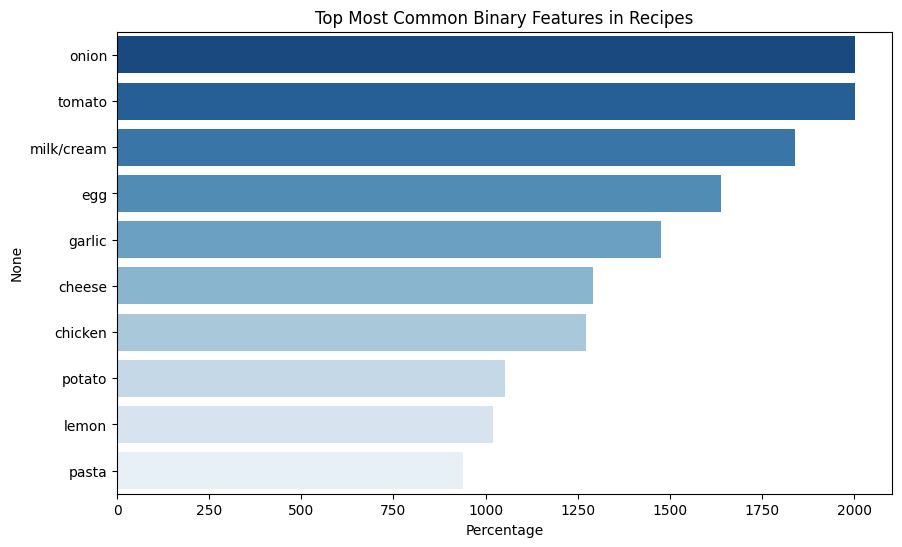

In [90]:
# Calculate the percentage of each binary feature

top_ingredients = df[ingredients].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette="Blues_r")
plt.title('Top Most Common Binary Features in Recipes')
plt.xlabel('Percentage')
plt.show()

## Scatter Plot 

### Calories vs Rating

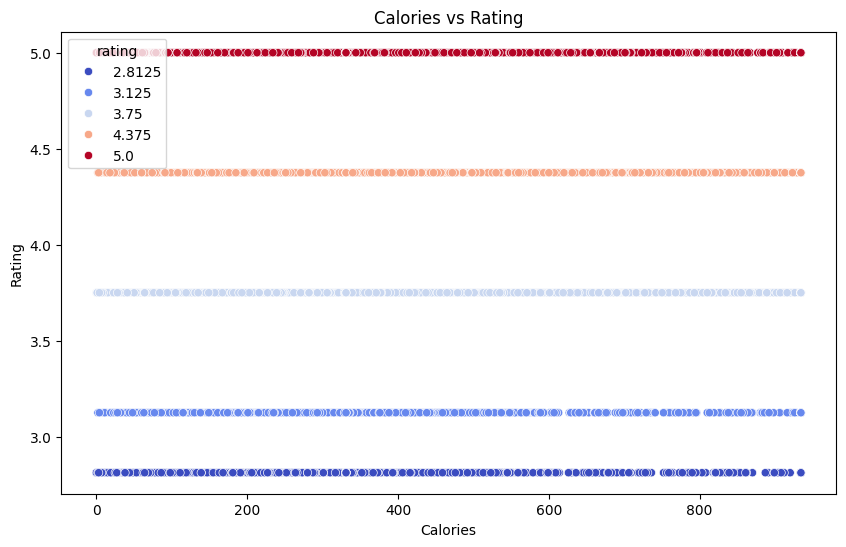

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calories', y='rating', data=df_new, hue='rating', palette="coolwarm")
plt.title('Calories vs Rating')
plt.xlabel('Calories')
plt.ylabel('Rating')
plt.show()

## Protein, Fat, and Sodium Distribution

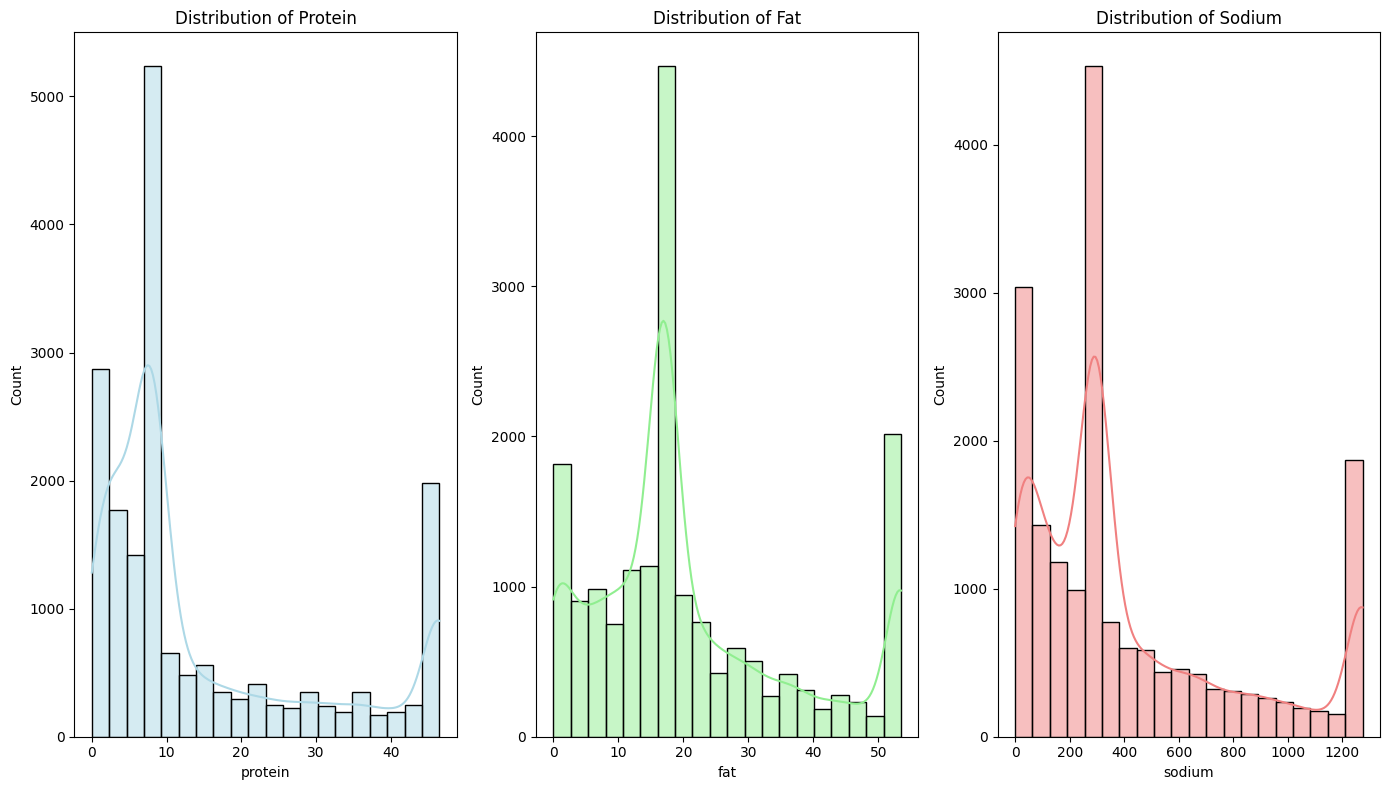

In [92]:
plt.figure(figsize=(14, 8))

# Protein Distribution
plt.subplot(1, 3, 1)
sns.histplot(df_new['protein'], bins=20, kde=True, color='lightblue')
plt.title('Distribution of Protein')

# Fat Distribution
plt.subplot(1, 3, 2)
sns.histplot(df_new['fat'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Fat')

# Sodium Distribution
plt.subplot(1, 3, 3)
sns.histplot(df_new['sodium'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Sodium')

plt.tight_layout()
plt.show()

## Pairplot for Multivariate Analysis

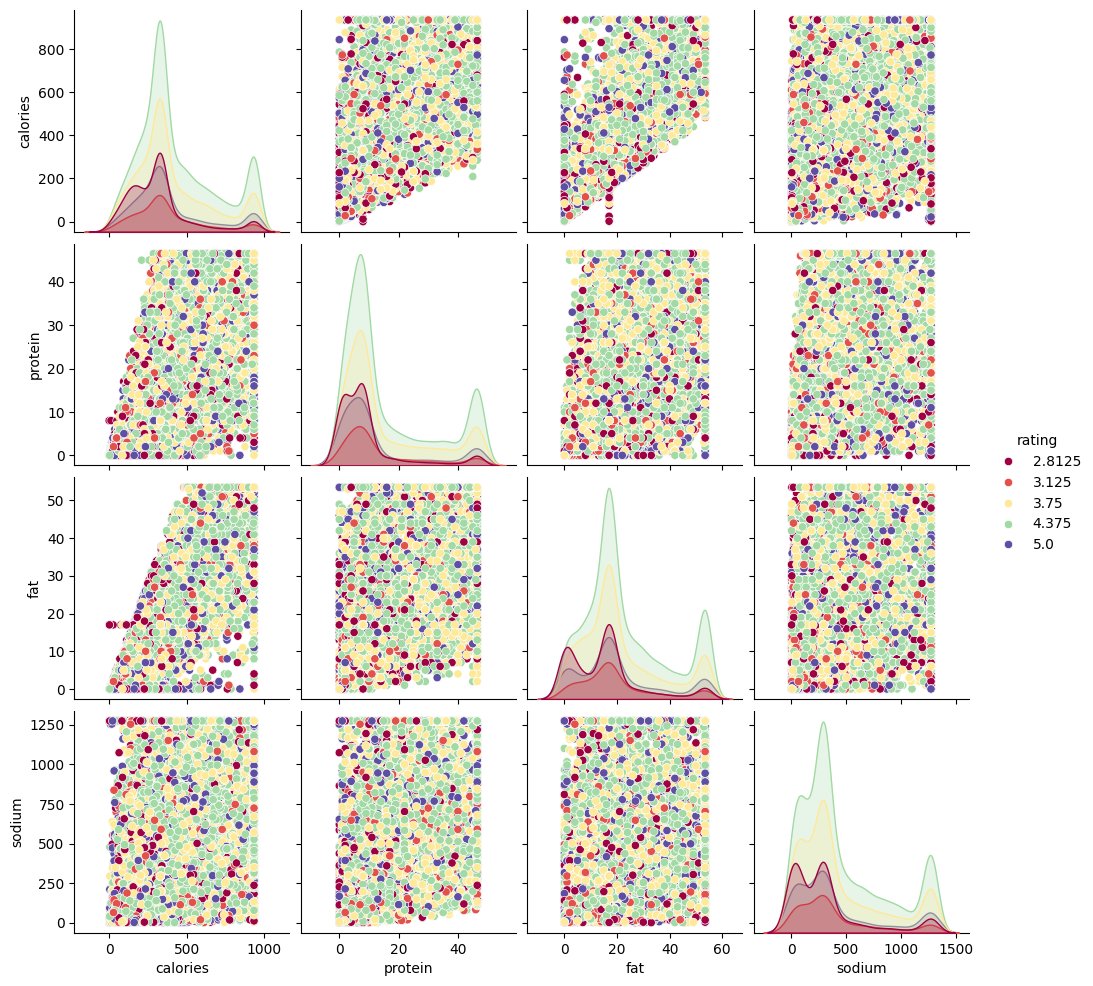

In [93]:
# A pairplot can visualize the relationships between multiple features
sns.pairplot(df_new[numeric_columns], hue='rating', palette="Spectral")
plt.show()

## Cooking Categories Analysis

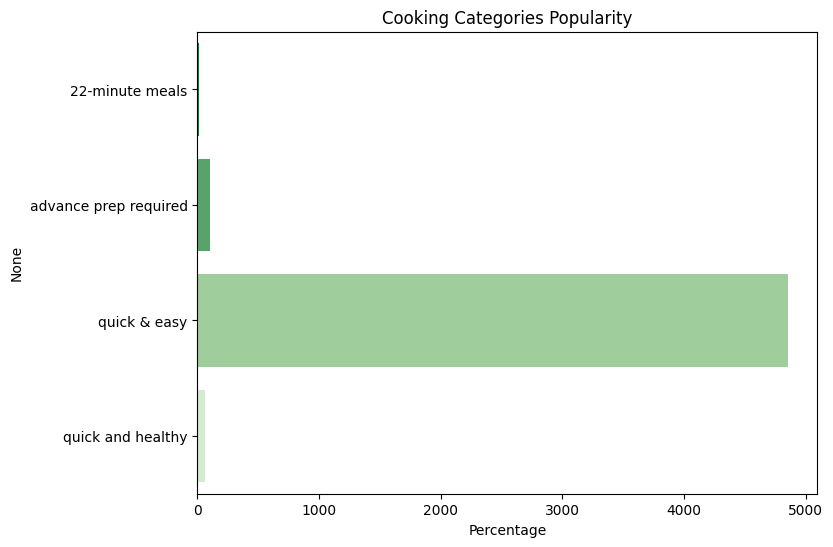

In [94]:
cooking_category = ["22-minute meals","advance prep required","quick & easy","quick and healthy"]
cooking_category_count = df[cooking_category].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=cooking_category_count.values, y=cooking_category_count.index, palette="Greens_r")
plt.title('Cooking Categories Popularity')
plt.xlabel('Percentage')
plt.show()

## Meal Time Preferences 

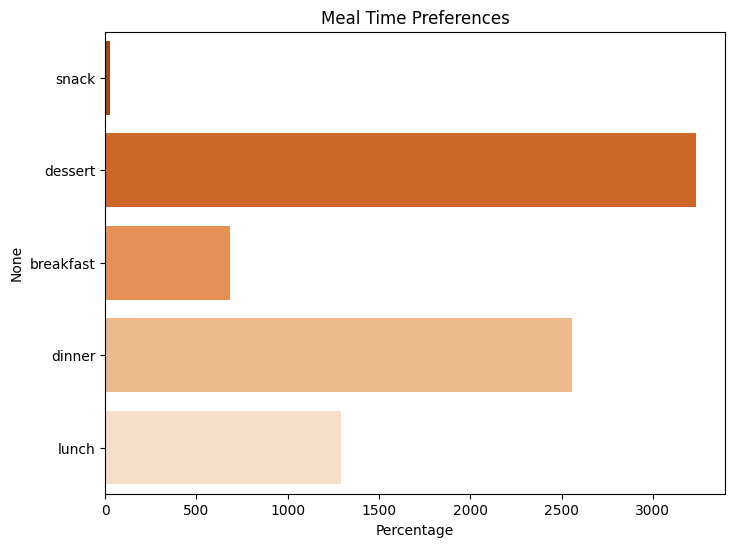

In [95]:
meal_time = ["snack","dessert", "breakfast","dinner", "lunch"]
meal_time_total = df[meal_time].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=meal_time_total.values, y=meal_time_total.index, palette="Oranges_r")
plt.title('Meal Time Preferences')
plt.xlabel('Percentage')
plt.show()


## Seasonal Recipes

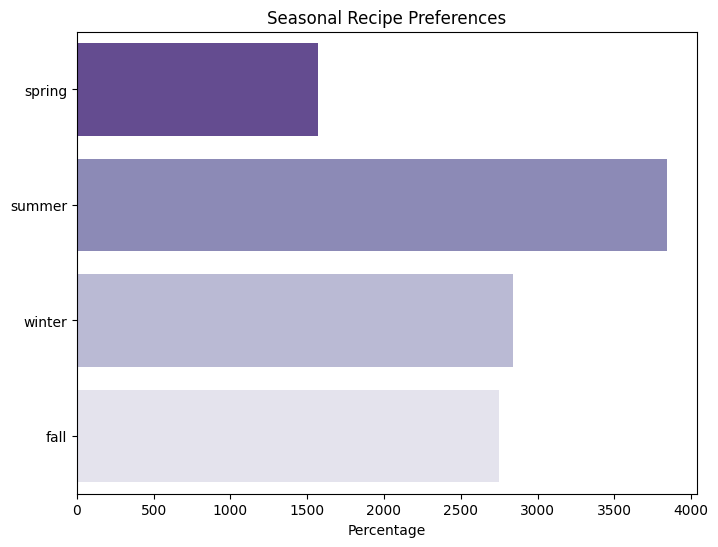

In [96]:
season = ["spring","summer","winter","fall"]
seasons_total = df_new[season].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=seasons_total.values, y=season, palette="Purples_r")
plt.title('Seasonal Recipe Preferences')
plt.xlabel('Percentage')
plt.show()


## Occasional Recipes

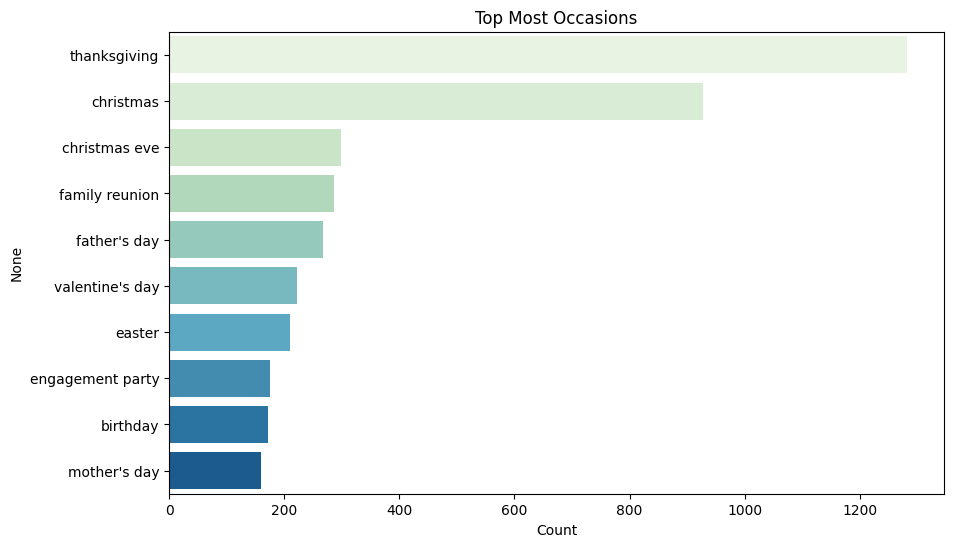

In [99]:
occasions = ["anniversary", "birthday", "christmas", "christmas eve", "easter", "father's day", "halloween", 
             "lunar new year", "mother's day", "new year's day", "new year's eve", "persian new year", "thanksgiving", 
             "valentine's day","diwali", "engagement party", "family reunion", "hanukkah", "persian new year", 
             "st. patrick's day", "wedding"]

top_occasions = df[occasions].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_occasions.values, y=top_occasions.index, palette="GnBu")
plt.title('Top Most Occasions')
plt.xlabel('Count')
plt.show()

## Nutrious Recipes

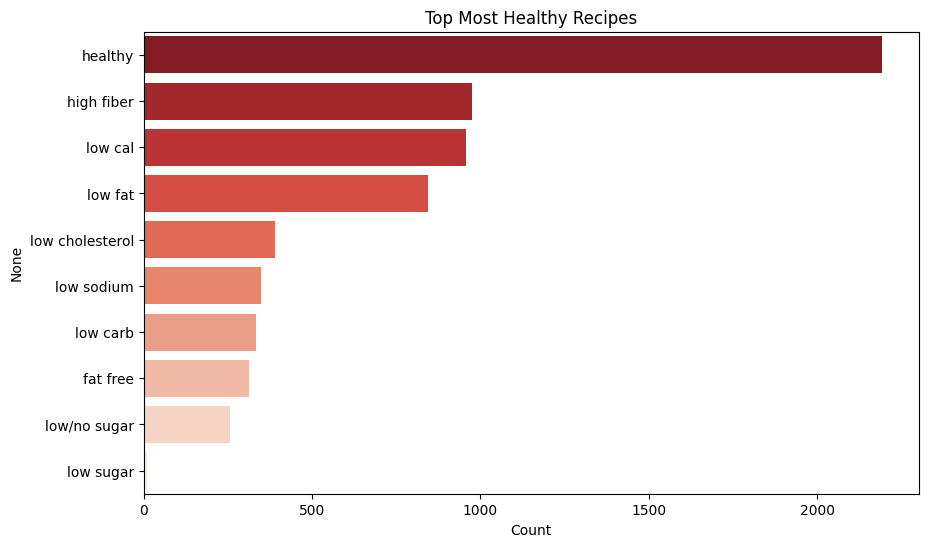

In [100]:
nutrious_value = ["fat free","healthy","high fiber","low cal","low carb","low cholesterol","low fat","low sodium",
                 "low sugar","low/no sugar"]

top_nutrious = df[nutrious_value].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_nutrious.values, y=top_nutrious.index, palette="Reds_r")
plt.title('Top Most Healthy Recipes')
plt.xlabel('Count')
plt.show()

## Recipe Complexity vs. Rating

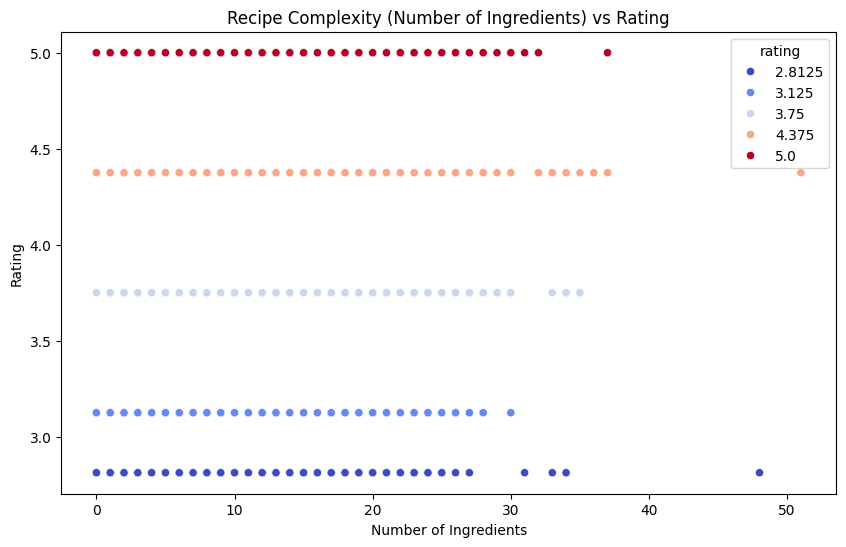

In [101]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='len_ingredients', y='rating', data=df_new, hue='rating', palette="coolwarm")
plt.title('Recipe Complexity (Number of Ingredients) vs Rating')
plt.xlabel('Number of Ingredients')
plt.ylabel('Rating')
plt.show()

# Recommendation

## Nutrients condition

In [102]:
def recipe_recommend(df, number_of_dishes, number_of_candidates, nut_conf):
    tmp = df.copy()
    candidates_list = []

    # create recommend-list {number_of_candidates} times
    for i in range(0,number_of_candidates):
        m = pl.LpProblem(sense=pl.LpMaximize) 
        tmp.loc[:,'v'] = [pl.LpVariable('x%d'%i, cat=pl.LpBinary) for i in range(len(tmp))]

        # maximize rating
        m += pl.lpDot(tmp["rating"], tmp["v"])

        # limit the number of recipes
        m += pl.lpSum(tmp["v"]) <= number_of_dishes

        # limit the calories
        m += pl.lpDot(tmp["calories"], tmp["v"]) >= nut_conf["cal_lo"]
        m += pl.lpDot(tmp["calories"], tmp["v"]) <= nut_conf["cal_up"]

        # limit the protein
        m += pl.lpDot(tmp["protein"], tmp["v"]) >= nut_conf["pro_lo"]
        m += pl.lpDot(tmp["protein"], tmp["v"]) <= nut_conf["pro_up"]

        # limit the fat (sum of fat / calories)
        m += pl.lpDot(tmp["fat"], tmp["v"]) >= nut_conf["fat_lo"]
        m += pl.lpDot(tmp["fat"], tmp["v"]) <= nut_conf["fat_up"]

        # limit the sodium
        m += pl.lpDot(tmp["sodium"], tmp["v"]) >= nut_conf["sod_lo"]
        m += pl.lpDot(tmp["sodium"], tmp["v"]) <= nut_conf["sod_up"]

        m.solve(pl.PULP_CBC_CMD(msg=0, options=['maxsol 1']))
        
        if m.status == 1:
            tmp.loc[:,'val'] = tmp["v"].apply(lambda x: pl.value(x))
            ret = tmp.query('val==1')["title"].values
            candidates_list.append(ret)
            # update dataframe (remove recommended title )
            tmp = tmp.query('val==0')
            
    return candidates_list


In [103]:
# Daily
male_japanese_day = {
    "cal_up" : 2700,
    "cal_lo" : 2600,
    "pro_up" : 65,
    "pro_lo" : 60,
    "fat_up" : 30,
    "fat_lo" : 20,
    "sod_up" : 7500,
    "sod_lo" : 7000
}
# Daily => 3 x meals
## 1 meal => Daily / 3
male_japanese_each = { k:v/3 for k, v in male_japanese_day.items() }

print("### Nutrients Conditions ###")
print(f"{np.round(male_japanese_each['cal_lo'],1)} =< calory <= {np.round(male_japanese_each['cal_up'],1)}")
print(f"{np.round(male_japanese_each['pro_lo'],1)} =< protain <= {np.round(male_japanese_each['pro_up'],1)}")
print(f"{np.round(male_japanese_each['fat_lo'],1)} =< fat <= {np.round(male_japanese_each['fat_up'],1)}")
print(f"{np.round(male_japanese_each['sod_lo'],1)} =< sodium <= {np.round(male_japanese_each['sod_up'],1)}")

### Nutrients Conditions ###
866.7 =< calory <= 900.0
20.0 =< protain <= 21.7
6.7 =< fat <= 10.0
2333.3 =< sodium <= 2500.0


In [104]:
# Daily
female_japanese_day = {
    "cal_up" : 2000,
    "cal_lo" : 1950,
    "pro_up" : 50,
    "pro_lo" : 45,
    "fat_up" : 30,
    "fat_lo" : 20,
    "sod_up" : 7500,
    "sod_lo" : 7000
}
# Daily => 3 x meals
## 1 meal => Daily / 3
female_japanese_each = { k:v/3 for k, v in female_japanese_day.items() }

print("### Nutrients Conditions ###")
print(f"{np.round(female_japanese_each['cal_lo'],1)} =< calory <= {np.round(female_japanese_each['cal_up'],1)}")
print(f"{np.round(female_japanese_each['pro_lo'],1)} =< protain <= {np.round(female_japanese_each['pro_up'],1)}")
print(f"{np.round(female_japanese_each['fat_lo'],1)} =< fat <= {np.round(female_japanese_each['fat_up'],1)}")
print(f"{np.round(female_japanese_each['sod_lo'],1)} =< sodium <= {np.round(female_japanese_each['sod_up'],1)}")

### Nutrients Conditions ###
650.0 =< calory <= 666.7
15.0 =< protain <= 16.7
6.7 =< fat <= 10.0
2333.3 =< sodium <= 2500.0


### For Adult Male

In [105]:
male_recipes = recipe_recommend(df_new, 3, 5, male_japanese_each)
for i, j in enumerate(male_recipes):
    print(f"{i} : " + " + ".join(j))

0 : Quince-Date Chutney  + Shaker Pickles  + Mixed Leafy Green Soup "Caldo Verde" with Chickpeas 
1 : Indian Pudding  + Sweet Garlic Soy Sauce  + Gingered Plum Barbeque Sauce 
2 : Korean BBQ Marinade  + Gingered Squash and Ham Soup with Cornmeal Dumplings  + Quince and Cranberry Sauce 
3 : Lime-Scented Rice  + Yam and Black Bean Burritos with Amaranth  + Pickled Peppers and Onions 
4 : Frozen Sunrise Margaritas  + Fig and Fennel Bread  + Midwestern Whole Wheat Dried Fruit Stuffing 


### For Adult Female

In [106]:
female_recipes = recipe_recommend(df_new, 3, 5, female_japanese_each)
for i, j in enumerate(female_recipes):
    print(f"{i} : " + " + ".join(j))

0 : Yogurt-Peach Semifreddo  + Thai Green Papaya Salad  + Top-Shelf Margaritas 
1 : Salty Dog  + Shaker Pickles  + Chicken-Stuffed Bell Peppers Spanish Style 
2 : Pickled Corn  + Sweet Garlic Soy Sauce  + Shredded Cabbage Salad With Pomegranate and Tomatoes 
3 : Cherry Cola Barbecue Sauce  + Pickled Sugar Snap Peas  + Cornbread with Bacon Crust 
4 : Sweet, Salty, and Sour Marinade  + Perfect Steamed Rice  + Butter-Braised Root Vegetables and Green Beans 


## Summer

In [107]:
male_recipes = recipe_recommend(df_new.query("summer==1"), 3, 5, male_japanese_each)
for i, j in enumerate(male_recipes):
    print(f"{i} : " + " + ".join(j))

0 : Gin, Tea, and Lemon Fizz  + Roast Beef Sandwiches with Whole Grain Mustard and Cranberries  + Shaker Pickles 
1 : Bantam Corn Relish  + Spring Rolls with Orange and Red Bell Pepper Salsa  + Margarita 
2 : Mango-Lime Ice  + Prosciutto with Melon  + Top-Shelf Margaritas 
3 : Basil Flatbread with Roasted Tomatoes and Basil Oil  + Lychee Compote with Raspberries and Champagne Gelée  + Soy-Lime Dipping Sauce 
4 : Slightly Sweet Dill Refrigerator Pickles  + Minted Cucumber and Bell Pepper Buttermilk Soup  + Gingered Brioche Summer Pudding with Sour Cream Mascarpone 


## Winter

In [108]:
male_recipes = recipe_recommend(df_new.query("winter==1"), 3, 5, male_japanese_each)
for i, j in enumerate(male_recipes):
    print(f"{i} : " + " + ".join(j))

0 : Crusty Mustard-Dill Meat Loaf  + Tangerine and Vanilla-Bean Marmalade  + Preserved Meyer Lemons 
1 : Cranberry-Orange Marmalade  + Asian Dumpling Soup  + Latin Spice Mix 
2 : Herbed Tomato Soup with Pasta  + Shrimp, Endive and Watercress Salad  + Baked Figs 
3 : Cornmeal Mush with Molasses and Ginger  + Fig and Fennel Bread  + Potato Parsnip Mash 


## On a busy day

In [111]:
male_recipes = recipe_recommend(df_new.query("len_ingredients <= 9 and len_directions <= 3"), 3, 5, male_japanese_each)
for i, j in enumerate(male_recipes):
    print(f"{i} : " + " + ".join(j))

0 : Sweet Chili Sauce  + Top-Shelf Margaritas  + Spicy Spaghetti with Clams and Red Bell Pepper 
1 : Cherry Cola Barbecue Sauce  + Sweet Garlic Soy Sauce  + Whole-Wheat Walnut Popovers 
2 : Radish-Cabbage Coleslaw  + Jamaican Hot Pepper Shrimp  + Rhubarb Collins 
3 : Pizza Dough  + Dill-Pickled Vegetables  + Cardamom Crescents 
4 : Pickled Sugar Snap Peas  + Cornmeal Mush with Molasses and Ginger  + Rice with Julienned Carrots 


# Saving cleaned file

In [115]:
saving_columns = ["title","rating","calories","protein","fat","sodium", "vegetarian"]
df_sav = df[saving_columns]
df_sav['const'] = 1
df_sav[["len_directions", "len_ingredients"]] = df_sav.title.swifter.apply(lambda x: get_recipe_info(x))

Pandas Apply: 100%|██████████| 18251/18251 [02:02<00:00, 148.66it/s]


In [116]:
ingredients_df = pd.DataFrame(df[ingredients].sum(),columns=['Total'])
ingredients_df['const'] = 1

occasions = ["anniversary", "birthday", "christmas", "christmas eve", "easter", "father's day", "halloween", 
             "lunar new year", "mother's day", "new year's day", "new year's eve", "persian new year", "thanksgiving", 
             "valentine's day","diwali", "engagement party", "family reunion", "hanukkah", "persian new year", 
             "st. patrick's day", "wedding"]
occasions_df = pd.DataFrame(df[occasions].sum(),columns=['Total'])
occasions_df['const'] = 1

cooking_category = ["22-minute meals","advance prep required","quick & easy","quick and healthy"]
cooking_category_df = pd.DataFrame(df[cooking_category].sum(),columns=['Total'])
cooking_category_df['const'] = 1

season = ["spring","summer","winter","fall"]
season_df = pd.DataFrame(df[season].sum(), columns=['Total'])
season_df['const'] = 1

meal_time_category = ["snack","dessert", "breakfast","dinner", "lunch"]
meal_time_df = pd.DataFrame(df[meal_time_category].sum(), columns=['Total'])
meal_time_df['const'] = 1

nutrious_value = ["fat free","healthy","high fiber","low cal","low carb","low cholesterol","low fat","low sodium",
                 "low sugar","low/no sugar"]
nutrious_value_df = pd.DataFrame(df[nutrious_value].sum(),columns=['Total']) 
nutrious_value_df['const'] = 1

In [117]:
df_sav.to_csv('Cleaned Data.csv')
ingredients_df.to_csv('ingredients.csv')
occasions_df.to_csv('occasions.csv')
cooking_category_df.to_csv('cooking_category.csv')
season_df.to_csv('seasons.csv')
meal_time_df.to_csv('meal_time.csv')
nutrious_value_df.to_csv('nutrious_value.csv')